## Geneformer Embeddings

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-09-22 09:58:20.762141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 09:58:20.833545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 09:58:20.984272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 09:58:20.985384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 44.8%
RAM Usage: 13.4%
Available RAM: 1.3T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


### Setup

In [13]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

import anndata
from anndata import AnnData

from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor

  warn(



In [14]:
# Load data
print("Loading data...")

#X_UKBB_raw, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='raw_mirror_interpolate', return_valid_genes=True)
X_UKBB_srs, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_UKBB = X_UKBB_srs
Y_UKBB = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

print(X.shape)
print(X.dtype)

Loading data...
X_UKBB_valid shape: (455, 15633)
torch.Size([455, 15633])
torch.float32


In [9]:
# === Paths ===
token_dict_path = "/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
gene_mapping_file = "/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"

# === Load dictionaries ===
with open(token_dict_path, 'rb') as f:
    token_dict = pickle.load(f)

with open(gene_mapping_file, 'rb') as f:
    gene_mapping = pickle.load(f)

# === Check and filter valid_genes ===
if 'valid_genes' not in locals():
    raise ValueError("valid_genes is not defined")

ensembl_ids = []
gene_symbols = []
unmapped_genes = []
tokenizable_genes = []
tokenizable_ensembl_ids = []
valid_indices = []

for i, gene in enumerate(valid_genes):
    if gene in gene_mapping:
        ensembl_id = gene_mapping[gene]
        if ensembl_id in token_dict:
            gene_symbols.append(gene)
            ensembl_ids.append(ensembl_id)
            tokenizable_genes.append(gene)
            tokenizable_ensembl_ids.append(ensembl_id)
            valid_indices.append(i)
        else:
            unmapped_genes.append(gene)
    else:
        unmapped_genes.append(gene)

# === Logging ===
print(f"✅ Total input genes: {len(valid_genes)}")
print(f"✅ Mapped to Ensembl: {len(ensembl_ids)}")
print(f"✅ Tokenizable genes: {len(tokenizable_genes)}")
print(f"❌ Unmapped or untokenizable: {len(unmapped_genes)}")

# Show sample mappings
print("\n🔍 Sample HGNC → Ensembl:")
for g, eid in zip(gene_symbols[:5], ensembl_ids[:5]):
    print(f"{g} → {eid}")

print("\n🔍 Sample Ensembl ID → Token ID:")
for eid in tokenizable_ensembl_ids[:5]:
    print(f"{eid} → {token_dict[eid]}")

# === Filter expression matrix ===
X = X[:, torch.tensor(valid_indices, dtype=torch.long, device=X.device)]

print(f"\n📐 Matrix shape after filtering: {X.shape}")

✅ Total input genes: 15633
✅ Mapped to Ensembl: 14111
✅ Tokenizable genes: 14111
❌ Unmapped or untokenizable: 1522

🔍 Sample HGNC → Ensembl:
A1BG → ENSG00000121410
A2M → ENSG00000175899
A2ML1 → ENSG00000166535
A3GALT2 → ENSG00000184389
A4GALT → ENSG00000128274

🔍 Sample Ensembl ID → Token ID:
ENSG00000121410 → 5114
ENSG00000175899 → 13651
ENSG00000166535 → 11687
ENSG00000184389 → 15062
ENSG00000128274 → 5926

📐 Matrix shape after filtering: torch.Size([455, 14111])


Setup AnnData file for tokenization

In [10]:
# === Convert expression matrix to NumPy (if not already)
X_np = X.detach().cpu().numpy()

# Shape matches the filtered matrix shape from above
n_cells, n_genes = X.shape

# Create synthetic data since we can't get X from GPU
#X_np = np.random.normal(loc=8.0, scale=1.5, size=(n_cells, n_genes)).astype(np.float32)

# === Create AnnData object
adata = sc.AnnData(X_np)

# === Set gene metadata (.var)
adata.var_names = pd.Index(tokenizable_ensembl_ids)  # must match token_dict keys
adata.var["gene_symbols"] = tokenizable_genes  # Use actual gene symbols
adata.var["ensembl_id"] = adata.var_names  # Store Ensembl IDs

# === Set cell metadata (.obs)
adata.obs_names = [f"cell_{i}" for i in range(adata.n_obs)]
adata.obs["filter_pass"] = True  # optional but suppresses warning in Geneformer
adata.obs["n_counts"] = adata.X.sum(axis=1)

# === Preview
print(adata)
print(adata.var.head())
print(adata.obs.head())

# === Save to disk
adata.write_h5ad("/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad")

AnnData object with n_obs × n_vars = 455 × 14111
    obs: 'filter_pass', 'n_counts'
    var: 'gene_symbols', 'ensembl_id'
                gene_symbols       ensembl_id
ENSG00000121410         A1BG  ENSG00000121410
ENSG00000175899          A2M  ENSG00000175899
ENSG00000166535        A2ML1  ENSG00000166535
ENSG00000184389      A3GALT2  ENSG00000184389
ENSG00000128274       A4GALT  ENSG00000128274
        filter_pass     n_counts
cell_0         True  7178.793457
cell_1         True  7031.651855
cell_2         True  6943.858887
cell_3         True  7142.404297
cell_4         True  6944.462402


In [11]:
adata

AnnData object with n_obs × n_vars = 455 × 14111
    obs: 'filter_pass', 'n_counts'
    var: 'gene_symbols', 'ensembl_id'

In [12]:
adata.X

array([[0.5787137 , 0.35566702, 0.4431227 , ..., 0.53469193, 0.48454788,
        0.45250824],
       [0.66455007, 0.41813716, 0.43127033, ..., 0.50342506, 0.42990837,
        0.50686204],
       [0.5041457 , 0.4095799 , 0.46770203, ..., 0.6615275 , 0.55417603,
        0.49575207],
       ...,
       [0.46144313, 0.7808404 , 0.59230256, ..., 0.44034186, 0.73507065,
        0.5086004 ],
       [0.46184424, 0.8327581 , 0.47412008, ..., 0.511465  , 0.758219  ,
        0.52686054],
       [0.49968532, 0.76076525, 0.6389178 , ..., 0.33557048, 0.65816593,
        0.50171894]], dtype=float32)

In [13]:
# Load your AnnData object
adata = anndata.read_h5ad("./data/geneformer/ahba_pseudocounts.h5ad")

In [14]:
tokenizer = TranscriptomeTokenizer(
    custom_attr_name_dict=None,     # or map .obs fields like {"subject_id": "subject"} if needed
    nproc=16,                       # your HPC can handle this
    chunk_size=512,
    #model_input_size=10,          # Geneformer-V2 default
    special_token=True,             # Geneformer-V2 default
    collapse_gene_ids=True,        # ❗️you've already mapped + filtered Ensembl IDs
    use_h5ad_index=True,            # ✅ your .var_names are Ensembl IDs
    keep_counts=True,              # set True if you want normalized counts kept
    model_version='V2',
    gene_median_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl",
    gene_mapping_file="/scratch/asr655/main_env/Geneformer/geneformer/ensembl_mapping_dict_gc104M.pkl"
)

# === Tokenize data
tokenizer.tokenize_data(
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/", #ahba_tokenized.dataset",
    output_prefix="ahba",
    file_format="h5ad"
)


Tokenizing /scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad
Creating dataset.


In [15]:
embex = EmbExtractor(
    model_type="Pretrained",
    num_classes=0,
    emb_mode="cell",
    #cell_emb_style="mean_pool",
    emb_layer=-1,
    #emb_label=["organ_major"],
    #labels_to_plot=["organ_major"],
    max_ncells=None,
    forward_batch_size=128,
    nproc=16,
    model_version="V2",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
)

In [16]:
model_path = "/scratch/asr655/main_env/Geneformer/Geneformer-V2-104M"
tokenized_data_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba.dataset"
output_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/embeddings"
output_prefix = 'ahba_embeddings'

embs = embex.extract_embs(
    model_directory=model_path,
    input_data_file=tokenized_data_path,
    output_directory=output_dir,
    output_prefix=output_prefix, 
    output_torch_embs=False
)

embs

  self.comm = Comm(**args)



  0%|          | 0/4 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.778645,0.475750,0.084761,0.150040,-1.382443,0.182720,0.209567,0.249018,0.920200,-0.103641,...,0.547782,0.055361,-0.131202,-0.158628,-0.305320,-0.293642,-0.713578,0.238280,-0.520300,0.135395
1,0.784846,0.487217,0.069282,0.132996,-1.418311,0.152067,0.170044,0.244444,0.914093,-0.113454,...,0.533490,0.023507,-0.100558,-0.182549,-0.341600,-0.299134,-0.673049,0.247155,-0.535856,0.152880
2,0.760454,0.477745,0.051587,0.117685,-1.428530,0.175518,0.217055,0.327233,0.902480,-0.119664,...,0.561233,0.018581,-0.127046,-0.162200,-0.315185,-0.320634,-0.687067,0.227379,-0.506902,0.125446
3,0.758843,0.422619,0.075226,0.083113,-1.422315,0.163556,0.225999,0.365103,0.882256,-0.090117,...,0.533026,0.002629,-0.165624,-0.139471,-0.314569,-0.304950,-0.701048,0.227589,-0.491275,0.074192
4,0.764813,0.477278,0.057033,0.098573,-1.423653,0.188368,0.199419,0.295248,0.924231,-0.101568,...,0.611134,0.003706,-0.129391,-0.133731,-0.325875,-0.327959,-0.694802,0.184116,-0.526962,0.111745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.772832,0.328434,0.202155,0.170661,-1.472770,0.059047,-0.031458,0.149104,0.762485,-0.120425,...,0.443836,0.088347,-0.179327,-0.086134,-0.400945,-0.264718,-0.454472,0.162327,-0.417477,-0.002884
451,0.795974,0.336290,0.195843,0.187982,-1.406517,0.024747,-0.014053,0.153427,0.737058,-0.109461,...,0.446953,0.034567,-0.143891,-0.071911,-0.415238,-0.280379,-0.428450,0.207827,-0.425868,0.016595
452,0.754049,0.325975,0.168599,0.189672,-1.500584,0.094451,-0.032119,0.220774,0.770511,-0.121945,...,0.443914,0.046913,-0.163431,-0.071819,-0.385198,-0.276683,-0.427702,0.128514,-0.437407,-0.002492
453,0.781470,0.321554,0.168880,0.163040,-1.524104,0.114040,-0.041062,0.279075,0.810453,-0.109268,...,0.407212,0.058853,-0.176365,-0.084852,-0.393107,-0.327857,-0.452758,0.119171,-0.417877,0.007683


In [ ]:
#embs

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.804708,0.328117,0.084708,0.109204,-1.438468,0.179605,0.107673,0.375794,0.819659,-0.104359,...,0.363271,-0.020324,-0.145606,-0.169693,-0.375403,-0.270829,-0.565194,0.288059,-0.498547,0.039869
1,0.804850,0.327244,0.088994,0.102874,-1.432647,0.164075,0.091645,0.371049,0.823925,-0.077230,...,0.365481,-0.000390,-0.147560,-0.155300,-0.374200,-0.276896,-0.558979,0.292965,-0.493245,0.039989
2,0.787976,0.310957,0.089233,0.110431,-1.433709,0.191170,0.109439,0.384029,0.825828,-0.103064,...,0.365506,-0.019243,-0.155607,-0.167536,-0.382345,-0.285314,-0.553699,0.280088,-0.495193,0.046967
3,0.768943,0.319893,0.080554,0.102309,-1.459153,0.184133,0.100394,0.390645,0.820166,-0.099232,...,0.364278,-0.004673,-0.165489,-0.170169,-0.383449,-0.260190,-0.555826,0.268359,-0.482690,0.041734
4,0.802890,0.321430,0.084933,0.071784,-1.459605,0.184824,0.105771,0.379481,0.829792,-0.102517,...,0.377764,-0.005633,-0.151622,-0.163597,-0.383055,-0.273477,-0.550516,0.266204,-0.487205,0.026703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.791758,0.305272,0.096563,0.060877,-1.467563,0.160586,0.095216,0.375901,0.798932,-0.103842,...,0.356790,-0.012309,-0.133354,-0.158731,-0.436181,-0.283158,-0.521596,0.239941,-0.460650,0.021704
451,0.794913,0.334351,0.122789,0.067972,-1.466727,0.149414,0.052352,0.367891,0.776219,-0.092964,...,0.369927,0.018328,-0.125754,-0.159095,-0.446521,-0.277174,-0.504113,0.263592,-0.461692,0.043759
452,0.774940,0.335578,0.098307,0.069271,-1.482275,0.185004,0.048623,0.400208,0.785879,-0.110019,...,0.381357,-0.016031,-0.126286,-0.156499,-0.416872,-0.295232,-0.513489,0.241740,-0.468005,0.026677
453,0.769074,0.336412,0.113536,0.068988,-1.489765,0.166603,0.061059,0.406021,0.799635,-0.079892,...,0.366171,0.008294,-0.124487,-0.162786,-0.409902,-0.264895,-0.524472,0.236746,-0.463607,0.019605


### Embedding analysis

In [24]:
from data.data_viz import plot_umap_embeddings_w_fc

In [25]:
embeddings_null = pd.read_csv("./data/gene_emb/geneformer_null/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()
embeddings_raw = pd.read_csv("./data/gene_emb/geneformer_raw/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()
embeddings_srs = pd.read_csv("./data/gene_emb/geneformer_srs/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()

In [26]:
embeddings_srs

array([[ 0.77869684,  0.4757497 ,  0.08474337, ...,  0.23827747,
        -0.5203107 ,  0.13535869],
       [ 0.78489566,  0.48726556,  0.06931148, ...,  0.24718332,
        -0.535854  ,  0.15288344],
       [ 0.7604604 ,  0.4778037 ,  0.05155047, ...,  0.22737947,
        -0.50694054,  0.12552486],
       ...,
       [ 0.7540491 ,  0.32600954,  0.16862306, ...,  0.12860705,
        -0.4374679 , -0.00251597],
       [ 0.7815001 ,  0.32154638,  0.16887793, ...,  0.11921036,
        -0.4178904 ,  0.0076398 ],
       [ 0.7845244 ,  0.34058517,  0.16977192, ...,  0.13862664,
        -0.4289601 ,  0.00811468]])

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



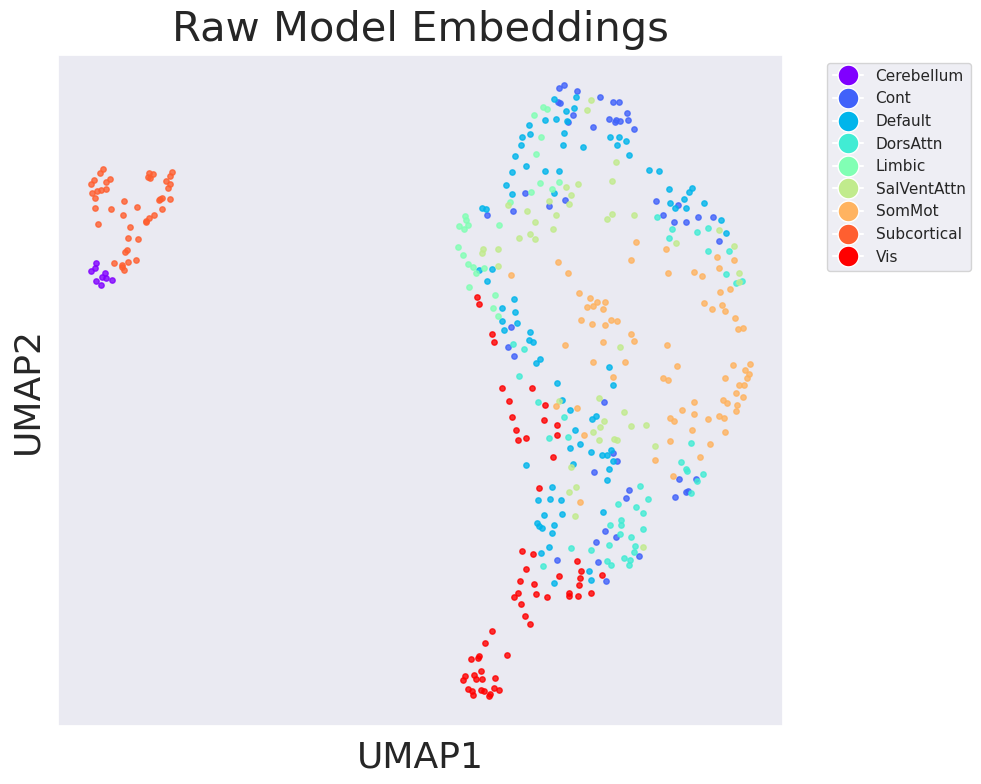

In [30]:
plot_umap_embeddings_w_fc(X_UKBB_valid, conn_matrix=None, edge_threshold=(-0.45,.75), network_labels=network_labels_UKBB, title='Raw Model Embeddings') 


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



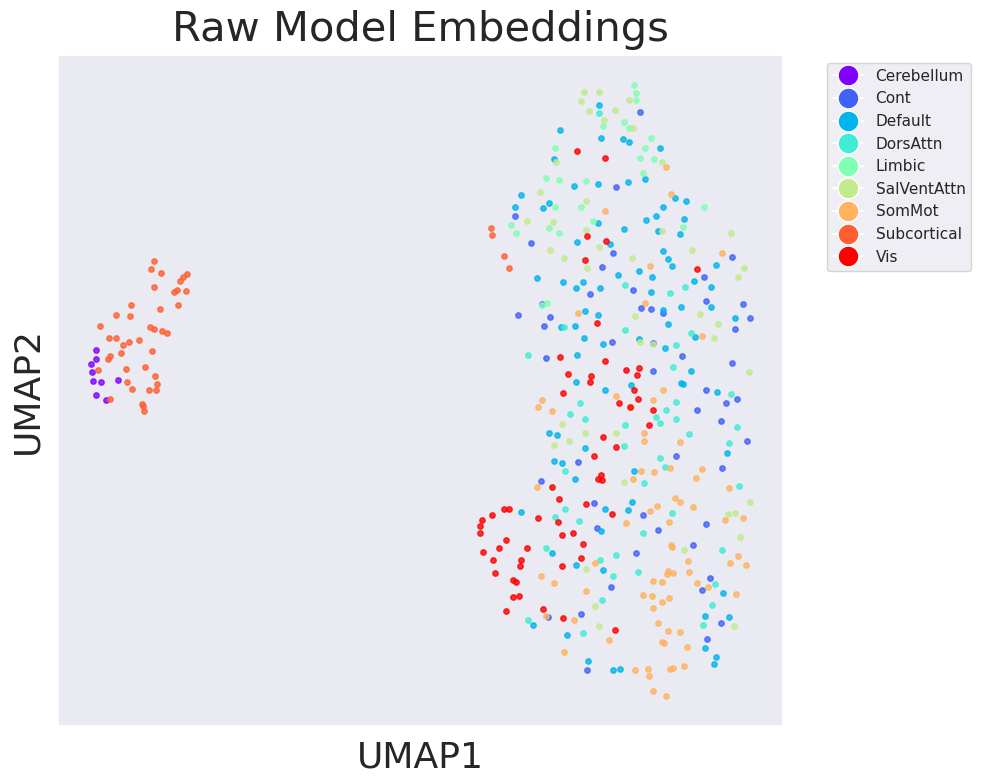

In [31]:
plot_umap_embeddings_w_fc(embeddings_raw, conn_matrix=None, edge_threshold=(-0.45,.75), network_labels=network_labels_UKBB, title='Raw Model Embeddings') 


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



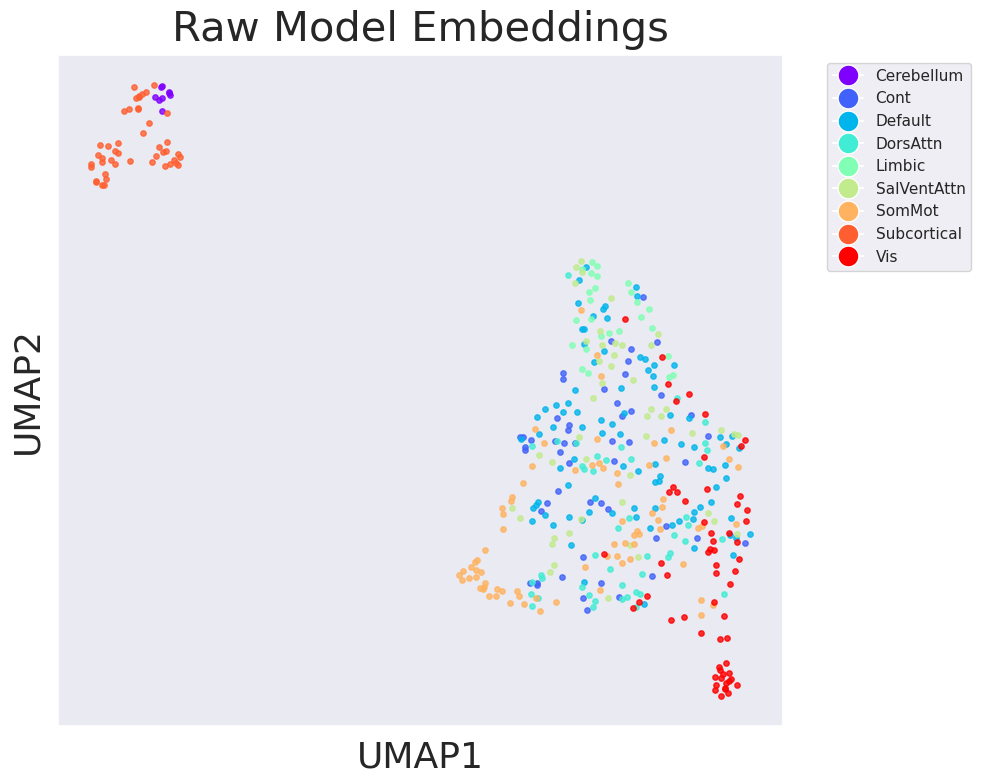

In [32]:
plot_umap_embeddings_w_fc(embeddings_srs, conn_matrix=None, edge_threshold=(-0.45,.75), network_labels=network_labels_UKBB, title='Raw Model Embeddings') 


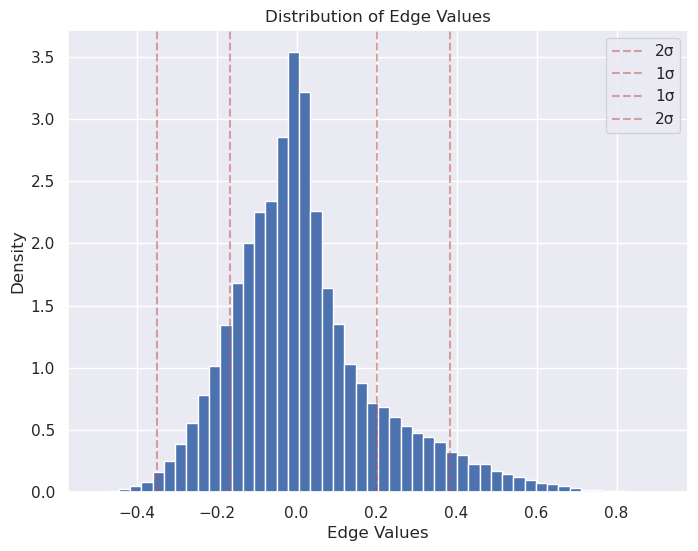

In [33]:
# Plot histogram of edge values
plt.figure(figsize=(8, 6))
plt.hist(Y_UKBB_valid.flatten(), bins=50, density=True)

# Add std dev markers
mean = np.mean(Y_UKBB_valid)
std = np.std(Y_UKBB_valid)
for i in [-2, -1, 1, 2]:
    plt.axvline(mean + i*std, color='r', linestyle='--', alpha=0.5, 
                label=f'{i}σ' if i > 0 else f'{abs(i)}σ')

plt.xlabel('Edge Values')
plt.ylabel('Density')
plt.title('Distribution of Edge Values')
plt.legend()
plt.show()

In [ ]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_umap_embeddings_w_fc

### SMT POOL EMBEDDINGS ###
from models.transformer_models import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel

# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

### PCA ###
X_pca = load_transcriptome(parcellation='S456', run_PCA='95var', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
X_pca = X_pca[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Project X to PCs explaining 95% variance explained
print(f"X_pca shape: {X_pca.shape}")

### PLS ###
# Project X to 10 PLS components
pls_model = PLSRegression(n_components=10, max_iter=1000, scale=True)
pls_model.fit(X_valid, Y_valid)

# Use x_rotations_ for fixed projection like in PLSEncoder
X_pls = np.matmul(X_valid, pls_model.x_rotations_)
print(f"X_pls shape: {X_pls.shape}")

### GENEFORMER ###
embeddings_raw = pd.read_csv("./data/gene_emb/geneformer_raw/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()
embeddings_srs = pd.read_csv("./data/gene_emb/geneformer_srs/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()


# SMT POOL EMBEDDINGS ###
smt_model = SharedSelfAttentionPoolingModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                          dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_pool_seed42_0_v1.pt"
smt_model.load_state_dict(torch.load(model_path))
smt_model.eval()
smt_model.to("cuda")
smt_model.encoder.eval()

# Get embeddings
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

with torch.no_grad():
    for batch in dataloader:
        embeddings_smt, _ = smt_model.encoder(batch[0], return_attn=True)
        embeddings_smt = embeddings_smt.cpu().numpy()


Loading data...
Number of components for 95% variance PCA: 27
X_pca shape: (455, 27)


  warnings.warn(



X_pls shape: (455, 10)
Number of learnable parameters in SMT model: 1069826


  warnings.warn(



Number of learnable parameters in SMT w/ CLS pooled model: 1086978


In [53]:
# SMT CLS POOL EMBEDDINGS ###
smt_cls_model = SharedSelfAttentionCLSPoolingModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                          dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned', cls_dropout=0.5)

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_cls_pool_seed42_0_v4.pt"
smt_cls_model.load_state_dict(torch.load(model_path))
smt_cls_model.eval()
smt_cls_model.to("cuda")
smt_cls_model.encoder.eval()

# Get embeddings
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")
dist_to_target = torch.zeros_like(coords[:, :1]).to("cuda")
#dist_to_target = torch.full_like(coords[:, :1], 60.0).to("cuda")
dataset = TensorDataset(X, coords, dist_to_target)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

with torch.no_grad():
    for batch in dataloader:
        embeddings_smt_cls, _ = smt_cls_model.encoder(batch[0], batch[1], batch[2], return_attn=True)
        embeddings_smt_cls = embeddings_smt_cls.cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT w/ CLS pooled model: 1086978


In [46]:
### AUTOENCODER ###
from models.transformer_models import AEEncoder
from torch.utils.data import TensorDataset, DataLoader

X1 = load_transcriptome(parcellation='S456', gene_list='1', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

X_valid1 = X1[valid_indices]
X_valid1 = torch.tensor(X_valid1, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(X_valid1)
dataloader = DataLoader(dataset, batch_size=X_valid1.shape[0], shuffle=False)

# Create autoencoder model with same path as reference code
ae_model = AEEncoder(input_dim=X_valid1.shape[1], n_components=128,
                    weights_path='./data/compressed_transcriptomics/',
                    device="cuda")
ae_model.eval()

# Get embeddings using dataloader
embeddings_ae = []
with torch.no_grad():
    for batch in dataloader:
        batch_embeddings = ae_model(batch[0].cuda()).cpu().numpy()
        embeddings_ae.append(batch_embeddings)
embeddings_ae = np.concatenate(embeddings_ae, axis=0)

print(f"Autoencoder embeddings shape: {embeddings_ae.shape}")


Loaded pretrained autoencoder weights from ./data/compressed_transcriptomics/autoencode_abagen_128_components.pt
Autoencoder embeddings shape: (455, 128)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Plotting UMAPs...


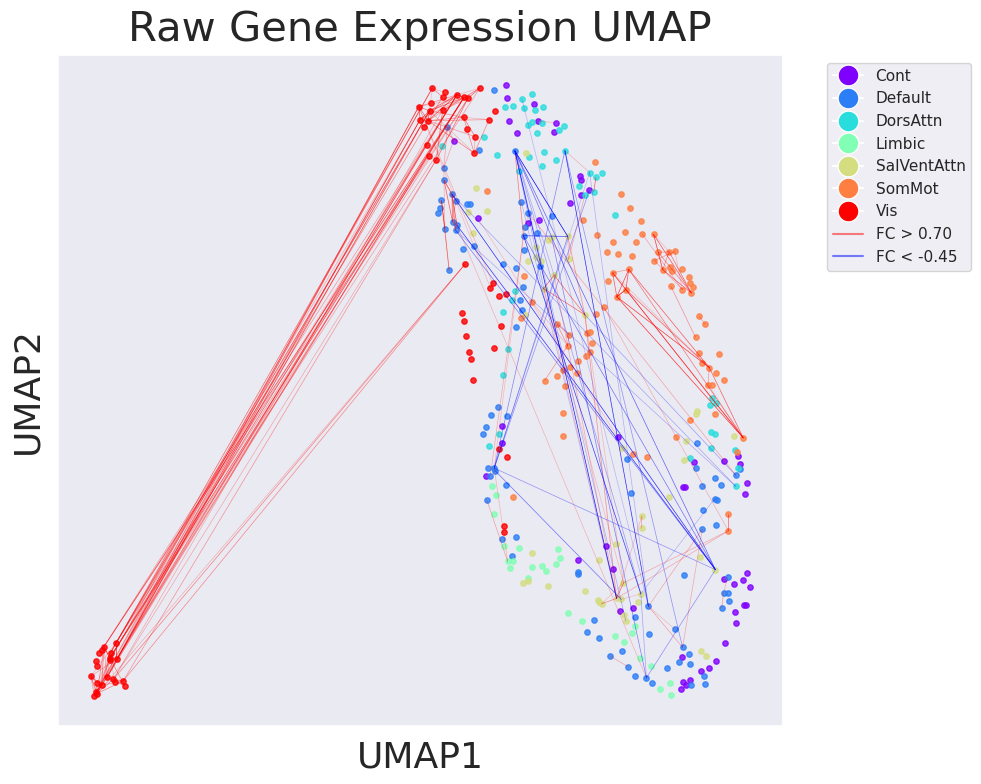

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



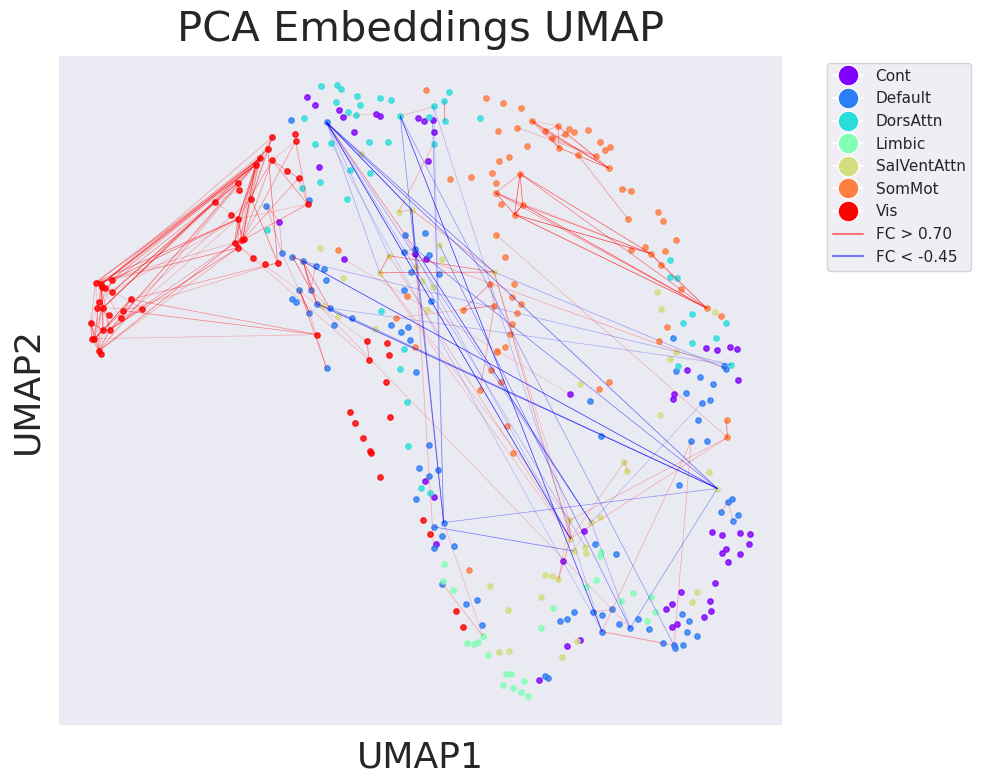

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



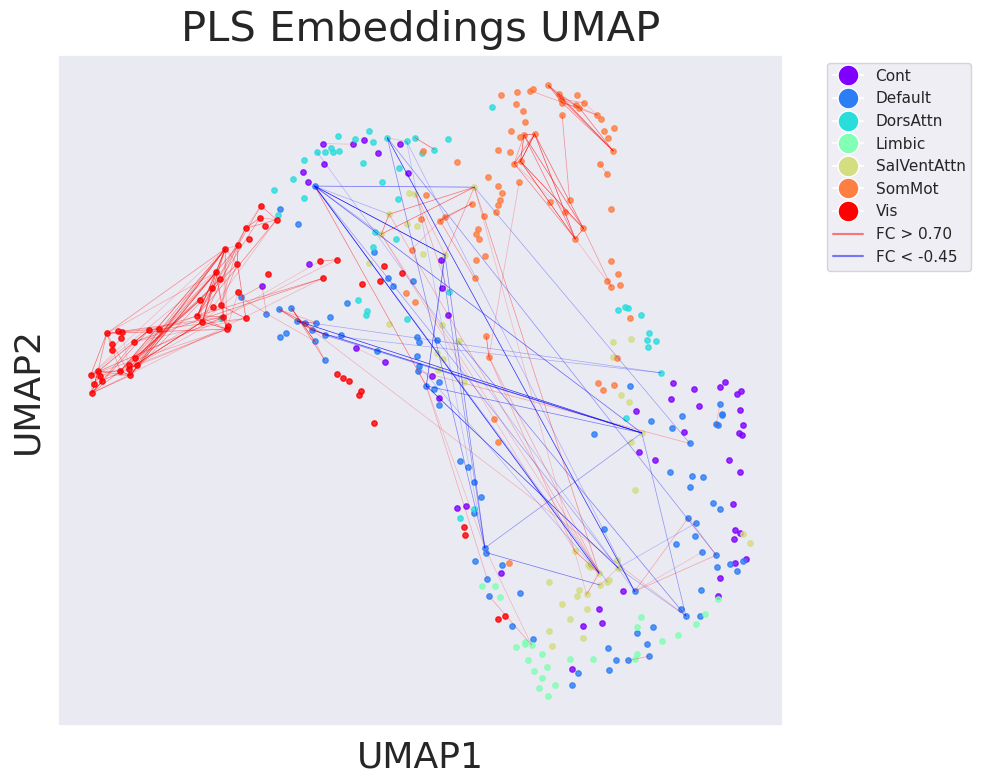

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



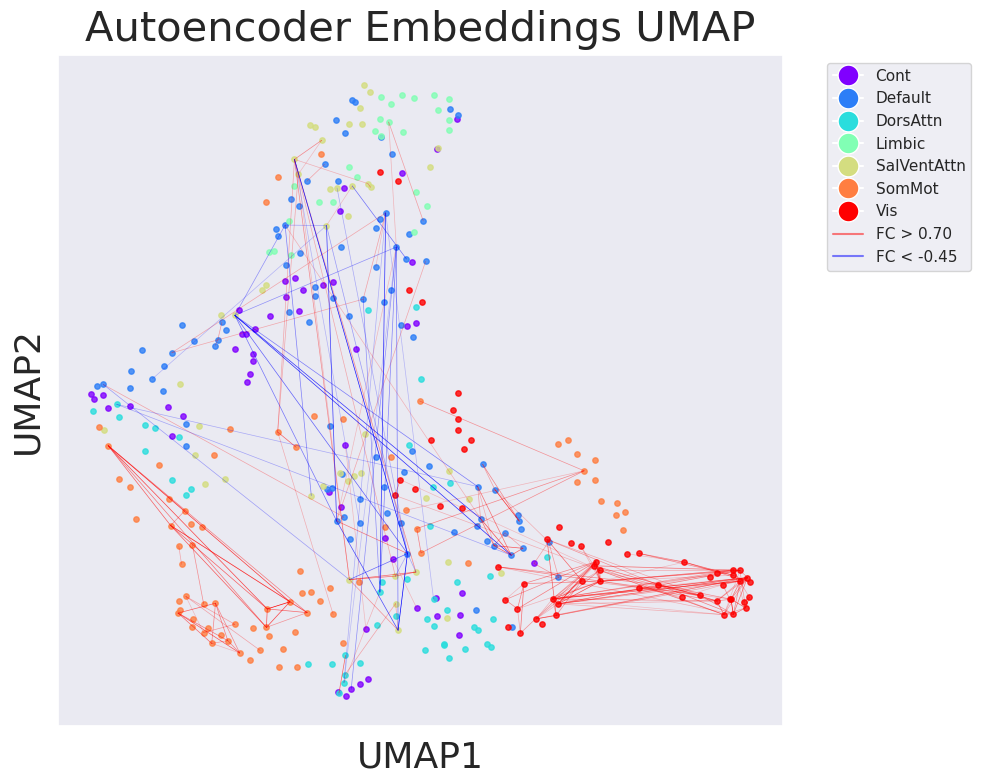

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



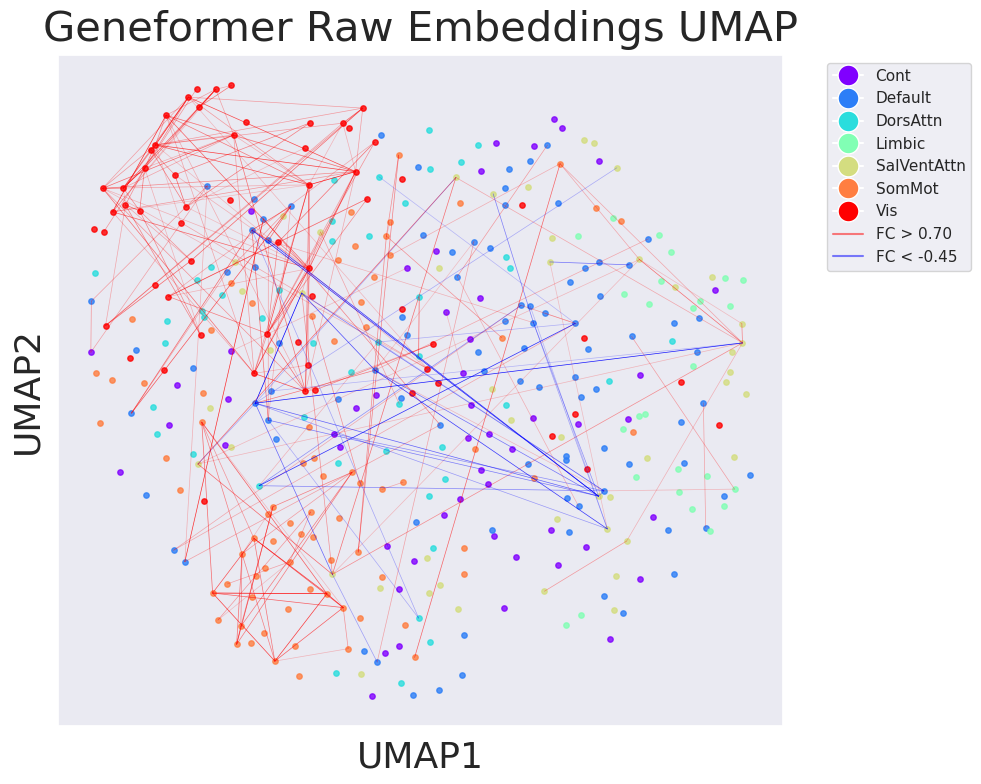

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



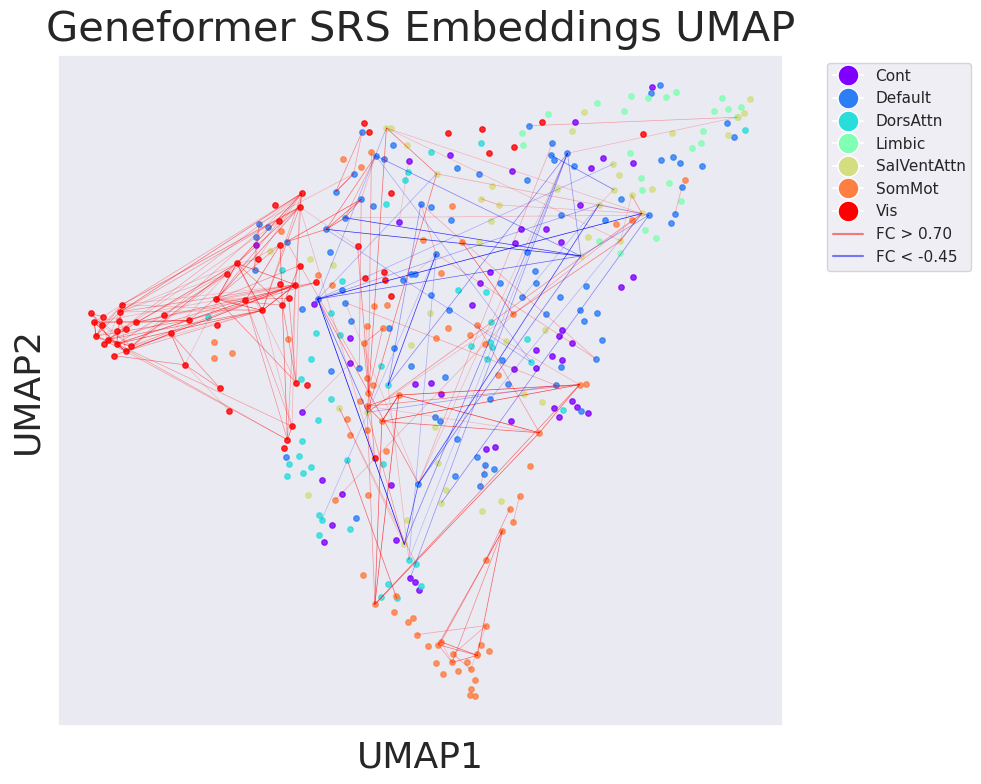

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



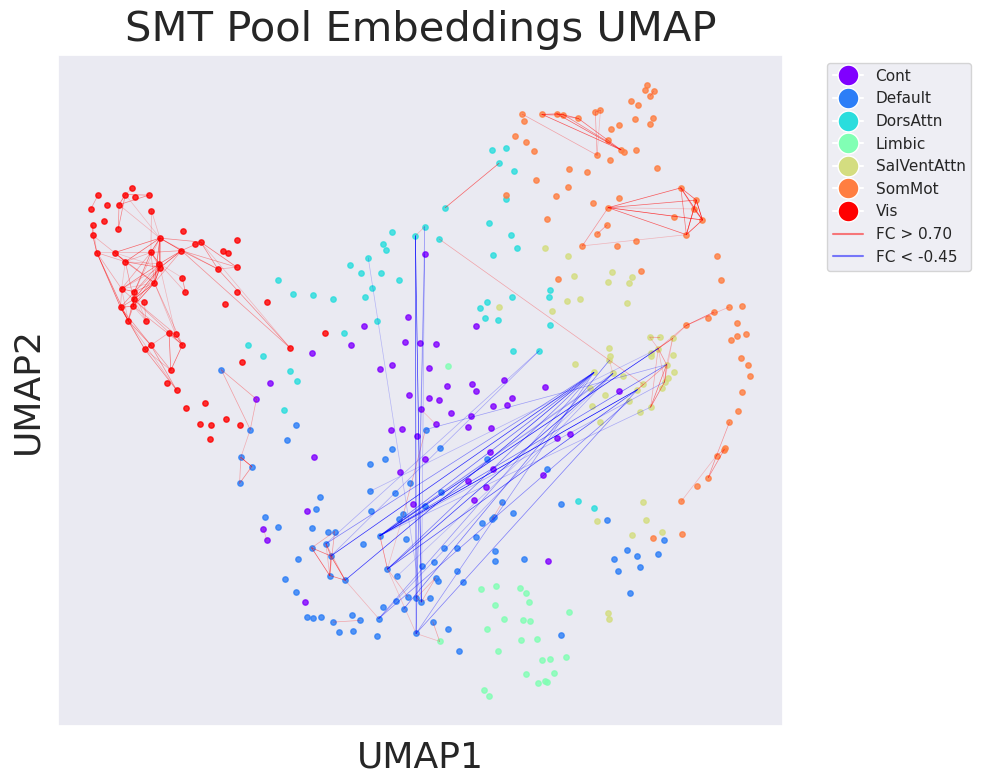

In [47]:
# Plot UMAP visualizations for each embedding type
print("Plotting UMAPs...")

neg_threshold, pos_threshold = -0.45, 0.7
omit_subcortical = True

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Raw Gene Expression UMAP", omit_subcortical=omit_subcortical)

# PCA embeddings 
plot_umap_embeddings_w_fc(X_pca, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="PCA Embeddings UMAP", omit_subcortical=omit_subcortical)

# PLS embeddings
plot_umap_embeddings_w_fc(X_pls, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="PLS Embeddings UMAP", omit_subcortical=omit_subcortical)

# Autoencoder embeddings
plot_umap_embeddings_w_fc(embeddings_ae, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Autoencoder Embeddings UMAP", omit_subcortical=omit_subcortical)


# Geneformer raw embeddings
plot_umap_embeddings_w_fc(embeddings_raw, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Geneformer Raw Embeddings UMAP", omit_subcortical=omit_subcortical)

# Geneformer SRS embeddings  
plot_umap_embeddings_w_fc(embeddings_srs, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Geneformer SRS Embeddings UMAP", omit_subcortical=omit_subcortical)

# SMT Pool embeddings
plot_umap_embeddings_w_fc(embeddings_smt, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT Pool Embeddings UMAP", omit_subcortical=omit_subcortical)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



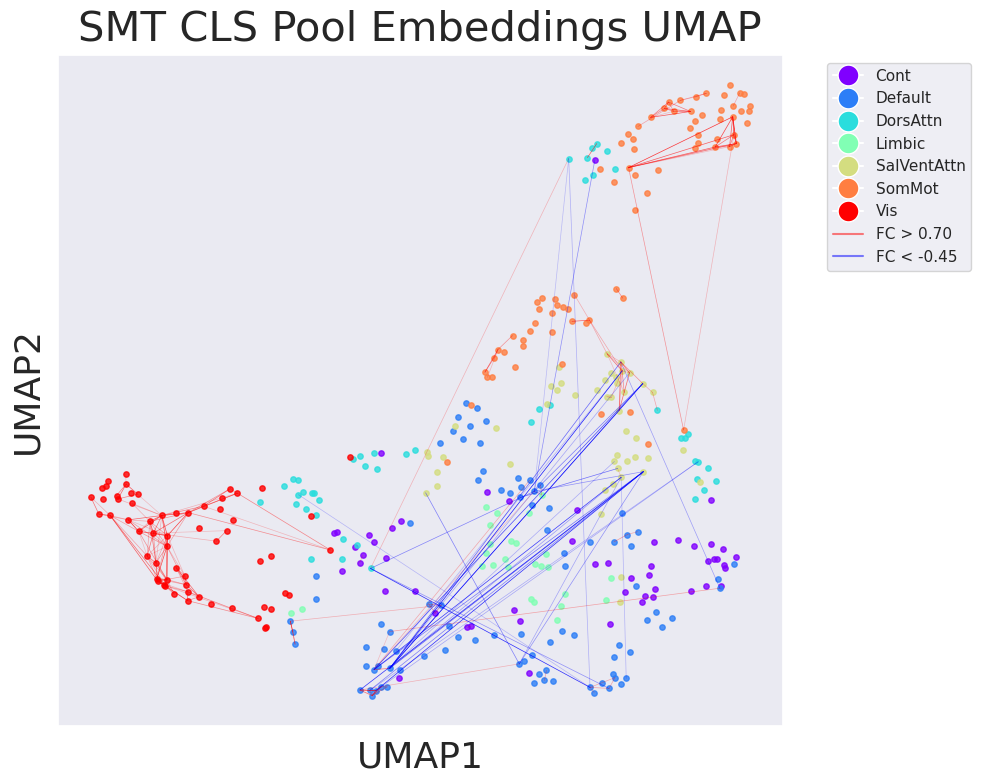

In [54]:

# SMT Pool embeddings
plot_umap_embeddings_w_fc(embeddings_smt_cls, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT CLS Pool Embeddings UMAP", omit_subcortical=omit_subcortical)
